# Dogs vs. Cats - CNN
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

## Configuration & Load Libraries

In [1]:
# set up notebook to display multiple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"## High-Level View

In [436]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
import gc # for cleaning memory
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
import platform
from datetime import datetime
import glob
import imageio
import random

In [416]:
# system info
platform.uname()

# Check for TensorFlow GPU access
tf.config.list_physical_devices()

# See TensorFlow version
tf.__version__

# See Keras version
(keras.__version__)

uname_result(system='Darwin', node='macbook-pro.lan', release='21.2.0', version='Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:41 PST 2021; root:xnu-8019.61.5~1/RELEASE_ARM64_T6000', machine='arm64', processor='arm')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

'2.7.0'

'2.7.0'

In [3]:
# Define function for clearing GPU memory
def reset_keras():
    tf.keras.backend.clear_session
    gc.collect()
reset_keras()

## Read Data

In [136]:
# build training set
trainf = glob.glob('train/*.jpg') # load file names of *img type

all = [0]*25000 # initialize labels as all cats

trainfiles = [] # initialize array
count = 0 # initialize counter
for i in trainf: # loop through images
    tempname = str('/Users/alisonau/tensorflow-test/' + str(trainf[count])) # get the filename
    if 'dog' in i: # labels dogs as 1
        all[count] = 1
    else:
        all[count] = 0
    tempdata = [all[count], tempname] # place the Label and filename in a temporary placeholder
    trainfiles.append(tempdata) # append to the initialized z vector
    count+=1 # increase counter
    
traindf = pd.DataFrame(trainfiles, columns=['label','id'])
traindf['label'] = traindf['label'].astype(str)
traindf.head()

,label,id
0,1,/Users/alisonau/tensorflow-test/train/dog.8011...
1,0,/Users/alisonau/tensorflow-test/train/cat.5077...
2,1,/Users/alisonau/tensorflow-test/train/dog.7322...
3,0,/Users/alisonau/tensorflow-test/train/cat.2718...
4,0,/Users/alisonau/tensorflow-test/train/cat.1015...


In [137]:
# build test set
testf = glob.glob('test/*.jpg')

testfiles = []
count = 0

for j in testf:
    tempname = str('/Users/alisonau/tensorflow-test/' + str(testf[count]))
    testfiles.append(tempname)
    count+=1

testdf = pd.DataFrame(testfiles, columns=['id'])
testdf.head()

,id
0,/Users/alisonau/tensorflow-test/test/9733.jpg
1,/Users/alisonau/tensorflow-test/test/63.jpg
2,/Users/alisonau/tensorflow-test/test/6400.jpg
3,/Users/alisonau/tensorflow-test/test/823.jpg
4,/Users/alisonau/tensorflow-test/test/4217.jpg


## Data Exploration

In [6]:
print('Number of training images:', len(trainf))
print('Number of test images:', len(testf))

Number of training images: 25000
Number of test images: 12500


In [417]:
trainf[0]

'train/dog.8011.jpg'

(-0.5, 379.5, 499.5, -0.5)

(-0.5, 158.5, 119.5, -0.5)

(-0.5, 392.5, 391.5, -0.5)

(-0.5, 499.5, 373.5, -0.5)

(-0.5, 398.5, 299.5, -0.5)

(-0.5, 466.5, 479.5, -0.5)

(-0.5, 498.5, 374.5, -0.5)

(-0.5, 499.5, 373.5, -0.5)

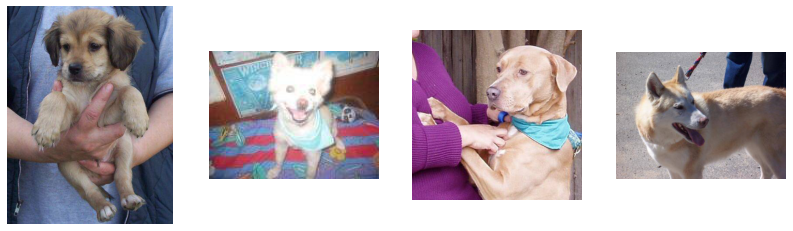

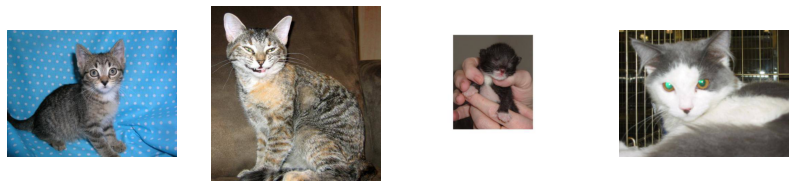

In [20]:
# sample of images
dogdf = traindf[traindf['label'] == "1"]
catdf = traindf[traindf['label'] == "0"]

fig, ax = plt.subplots(1,4, figsize=[14, 4])  #set first figure
fig2, ax2 = plt.subplots(1,4, figsize=[14, 4]) #set second figure

for i in range(4): # plot dogs
    f = imageio.imread(dogdf['id'].iloc[i])
    ax[i].imshow(f)
    ax[i].axis('off')
for i in range(4): # plot cats
    f = imageio.imread(catdf['id'].iloc[i])
    ax2[i].imshow(f)
    ax2[i].axis('off')

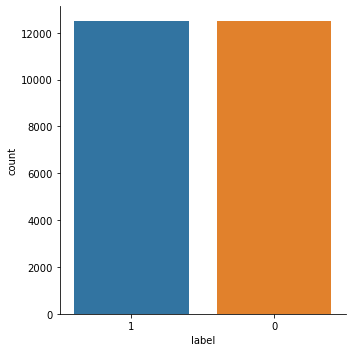

In [21]:
sns.catplot(x='label', kind='count', data=traindf);
# same number of dogs and cats

## Flow from DataFrame

In [149]:
# split train and validation
random.seed(1234)

idx = np.random.rand(len(traindf)) < 0.8 # 80/20 train/validation split
train = traindf[idx]
val = traindf[~idx]

In [394]:
mybatch = 32
mysize = 130

train_datagen = ImageDataGenerator(rescale=1./255, # min max scalings
                                   rotation_range=30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=False
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=True,
                                                    batch_size=mybatch,
                                                    seed=42)
                                                    
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe=val,
                                                x_col='id',
                                                y_col='label',
                                                class_mode='binary',
                                                target_size=(mysize, mysize),
                                                shuffle=True,
                                                batch_size=mybatch,
                                                seed=42)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf,
                                                  directory=None,
                                                  x_col='id',
                                                  color_mode='rgb',
                                                  target_size=(mysize, mysize),
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 20019 validated image filenames belonging to 2 classes.
Found 4981 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [434]:
# check generator data
train_generator[0][0].shape # 32 images per batch with 130x130 pixels with 3 values each for RGB
train_generator[0]

(32, 130, 130, 3)

(array([[[[0.20750256, 0.18383566, 0.14553551],
          [0.3257477 , 0.20277436, 0.16307876],
          [0.36351994, 0.21081594, 0.1432005 ],
          ...,
          [0.41035706, 0.20519224, 0.09541571],
          [0.39607847, 0.20046936, 0.09474345],
          [0.39607847, 0.20872705, 0.1057537 ]],
 
         [[0.14711475, 0.1746462 , 0.13240772],
          [0.29587778, 0.19728406, 0.16474752],
          [0.35072333, 0.20853797, 0.15155156],
          ...,
          [0.39607847, 0.2106812 , 0.10835923],
          [0.39607847, 0.21893887, 0.11936948],
          [0.39607847, 0.22291824, 0.12243425]],
 
         [[0.13130698, 0.17254902, 0.14055678],
          [0.23548995, 0.1880946 , 0.15161973],
          [0.3336572 , 0.20459962, 0.15942822],
          ...,
          [0.39607847, 0.22259253, 0.12080579],
          [0.39607847, 0.22121626, 0.11392438],
          [0.39607847, 0.21983999, 0.10704298]],
 
         ...,
 
         [[0.68652207, 0.70220834, 0.7061299 ],
          [0.68777

## Modeling

### Custom Model

In [435]:
# Build model
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(mysize, mysize, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 activation_34 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 activation_35 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                

In [400]:
reset_keras()

step_size = train_generator.n//train_generator.batch_size
checkpoint = keras.callbacks.ModelCheckpoint("model1.h5",
                                             monitor='val_binary_accuracy',
                                             save_best_only=True)
early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                      patience=5,
                                      restore_best_weights=True)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

start = datetime.now()

history = model.fit(train_generator, 
                    steps_per_epoch=step_size, 
                    epochs=30, 
                    callbacks=[checkpoint, early],
                    validation_data=val_generator)  

end = datetime.now()
print('Time to fit:', end-start)


Epoch 1/30


2022-02-27 01:40:56.144797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.6209 - binary_accuracy: 0.6564

2022-02-27 01:41:58.856264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 70s 110ms/step - loss: 0.6209 - binary_accuracy: 0.6564 - val_loss: 0.5824 - val_binary_accuracy: 0.6691
Epoch 2/30
625/625 [==============================] - 69s 111ms/step - loss: 0.5313 - binary_accuracy: 0.7341 - val_loss: 0.4528 - val_binary_accuracy: 0.7876
Epoch 3/30
625/625 [==============================] - 69s 110ms/step - loss: 0.4961 - binary_accuracy: 0.7675 - val_loss: 0.4669 - val_binary_accuracy: 0.7878
Epoch 4/30
625/625 [==============================] - 70s 112ms/step - loss: 0.4672 - binary_accuracy: 0.7832 - val_loss: 0.4279 - val_binary_accuracy: 0.8031
Epoch 5/30
625/625 [==============================] - 69s 110ms/step - loss: 0.4476 - binary_accuracy: 0.7964 - val_loss: 0.4014 - val_binary_accuracy: 0.8233
Epoch 6/30
625/625 [==============================] - 69s 110ms/step - loss: 0.4302 - binary_accuracy: 0.8076 - val_loss: 0.4217 - val_binary_accuracy: 0.8227
Epoch 7/30
625/625 [==============================] - 69s

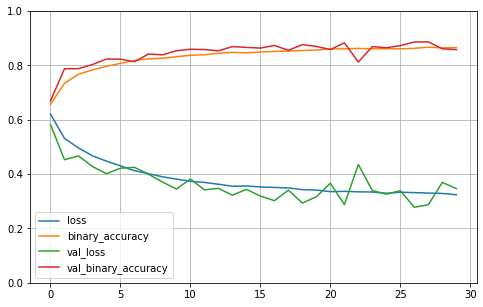

In [401]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [402]:
# set shuffle to False for accuracy metrics
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=False,
                                                    batch_size=mybatch,
                                                    seed=42)

Found 20019 validated image filenames belonging to 2 classes.


In [403]:
# predict on train and test
train_generator.reset()
test_generator.reset()

train_pred = model.predict(train_generator, verbose=1)
test_pred = model.predict(test_generator, verbose=1)

  1/626 [..............................] - ETA: 2:12

2022-02-27 02:21:18.527700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


    1/12500 [..............................] - ETA: 38:48

2022-02-27 02:22:19.633159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12500/12500 [==============================] - 26s 2ms/step


In [404]:
# create labels based on output which are probabilities
train_predlab = train_pred.copy()

train_predlab[train_predlab > 0.5] = 1
train_predlab[train_predlab <= 0.5] = 0

In [405]:
print(classification_report(train_generator.labels, train_predlab))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86     10030
           1       0.93      0.76      0.84      9989

    accuracy                           0.85     20019
   macro avg       0.86      0.85      0.85     20019
weighted avg       0.86      0.85      0.85     20019



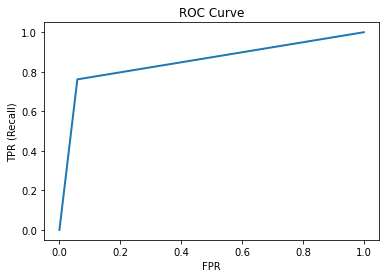

In [406]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(train_generator.labels, train_predlab)

sns.lineplot(x=fpr, y=tpr, linewidth=2)
plt.title('ROC Curve')
plt.xlabel('FPR'),
plt.ylabel('TPR (Recall)');

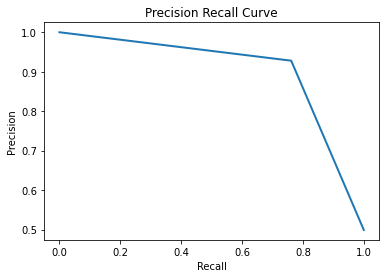

In [407]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(train_generator.labels, train_predlab)

sns.lineplot(x=recalls, y=precisions, linewidth=2)
plt.title('Precision Recall Curve')
plt.xlabel('Recall'),
plt.ylabel('Precision');

Text(0.5, 1.0, 'Looks like a cat with probability 0.6411423087120056')

Text(0.5, 1.0, 'Looks like a cat with probability 0.8421854823827744')

Text(0.5, 1.0, 'Looks like a dog with probability 0.8783617615699768')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9999595880508423')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9969992870464921')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9450567327439785')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9976750016212463')

Text(0.5, 1.0, 'Looks like a dog with probability 0.8042383790016174')

Text(0.5, 1.0, 'Looks like a cat with probability 0.8647278249263763')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9567111022770405')

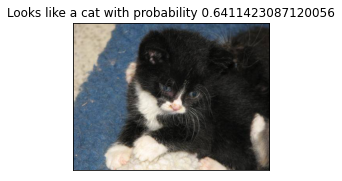

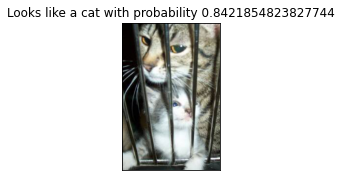

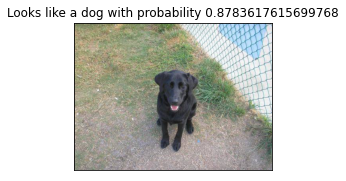

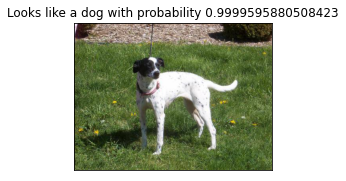

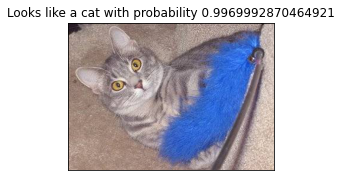

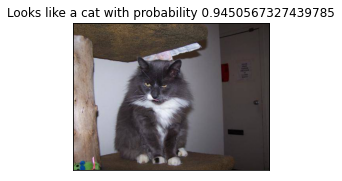

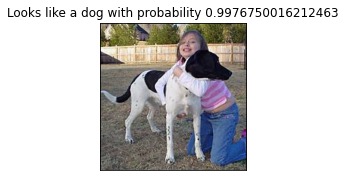

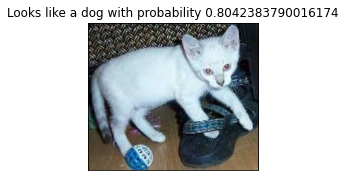

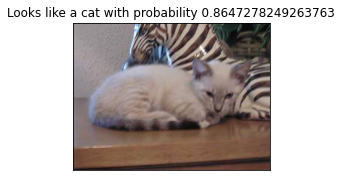

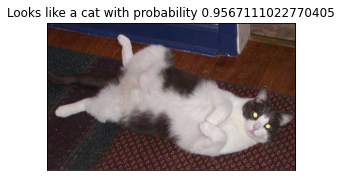

In [408]:
# sample of predictions on test set
n = 10
for i, (index, row) in enumerate(testdf.iterrows()):
    if i >= n:
        break
    fig = plt.figure(figsize=(8, 32))
    img = load_img(row['id'])
    subfig = fig.add_subplot(n, 1, i + 1)
    pred = test_pred[i][0]
    pred_label = 'dog' if pred > 0.5 else 'cat'
    pred = pred if pred > 0.5 else 1-pred
    plt.title('Looks like a {0} with probability {1}'.format(pred_label, pred))
    f = plt.imshow(img)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

In [411]:
results = pd.DataFrame({'id': pd.Series(testdf.id.values),
                        'label': pd.Series(test_pred.T[0])})
results.to_csv('results_custommodel.csv', index=False)
results.head(5)

,id,label
0,/Users/alisonau/tensorflow-test/test/9733.jpg,0.36
1,/Users/alisonau/tensorflow-test/test/63.jpg,0.16
2,/Users/alisonau/tensorflow-test/test/6400.jpg,0.88
3,/Users/alisonau/tensorflow-test/test/823.jpg,1.00
4,/Users/alisonau/tensorflow-test/test/4217.jpg,0.00


### VGG16 Model

In [76]:
# Build model
cnn2 = VGG16(weights='imagenet', include_top=False, input_shape = (mysize, mysize, 3))

# Build the rest of the model
x = cnn2.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
predictions = keras.layers.Dense(1, activation="sigmoid", name='classifier')(x)
model2=keras.Model(inputs = cnn2.input, outputs = predictions)
model2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 130, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 130, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 130, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 65, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 65, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 65, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [433]:
# set shuffle back to True
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=True,
                                                    batch_size=mybatch,
                                                    seed=42)

Found 20019 validated image filenames belonging to 2 classes.


In [78]:
# fit model
reset_keras()

checkpoint = keras.callbacks.ModelCheckpoint("modelvgg16.h5",
                                             monitor='val_binary_accuracy',
                                             save_best_only=True)
early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                      patience=5,
                                      restore_best_weights=True)

SGD = tf.keras.optimizers.SGD(learning_rate = 0.0001, nesterov=True)
model2.compile(optimizer=SGD,
              loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

start = datetime.now()

history2 = model2.fit(train_generator, 
                    # steps_per_epoch=step_size, 
                    epochs=20, 
                    callbacks=[checkpoint, early],
                    validation_data=val_generator)  

end = datetime.now()
print('Time to fit:', end-start)


Epoch 1/20


2022-02-25 13:30:51.771014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


622/622 [==============================] - ETA: 0s - loss: 0.7026 - binary_accuracy: 0.5274

2022-02-25 13:34:21.172208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


622/622 [==============================] - 224s 358ms/step - loss: 0.7026 - binary_accuracy: 0.5274 - val_loss: 0.6492 - val_binary_accuracy: 0.6684
Epoch 2/20
622/622 [==============================] - 223s 358ms/step - loss: 0.6255 - binary_accuracy: 0.6618 - val_loss: 0.5518 - val_binary_accuracy: 0.7652
Epoch 3/20
622/622 [==============================] - 223s 358ms/step - loss: 0.5201 - binary_accuracy: 0.7573 - val_loss: 0.4244 - val_binary_accuracy: 0.8163
Epoch 4/20
622/622 [==============================] - 223s 358ms/step - loss: 0.4104 - binary_accuracy: 0.8226 - val_loss: 0.3227 - val_binary_accuracy: 0.8665
Epoch 5/20
622/622 [==============================] - 223s 358ms/step - loss: 0.3311 - binary_accuracy: 0.8596 - val_loss: 0.2705 - val_binary_accuracy: 0.8885
Epoch 6/20
622/622 [==============================] - 387s 622ms/step - loss: 0.2886 - binary_accuracy: 0.8763 - val_loss: 0.2647 - val_binary_accuracy: 0.8897
Epoch 7/20
622/622 [==============================]

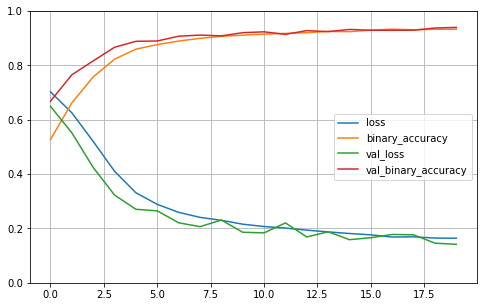

In [193]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

# probably could have kept running more epochs

In [299]:
# set shuffle to False for accuracy metrics
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=False,
                                                    batch_size=mybatch,
                                                    seed=42)

Found 20019 validated image filenames belonging to 2 classes.


In [316]:
# predict on train and test
train_generator.reset()
test_generator.reset()

train_pred2 = model2.predict(train_generator, verbose=1)
test_pred2 = model2.predict(test_generator, verbose=1)

12500/12500 [==============================] - 110s 9ms/step


In [317]:
# create labels based on output which are probabilities
train_pred2lab = train_pred2.copy()

train_pred2lab[train_pred2lab > 0.5] = 1
train_pred2lab[train_pred2lab <= 0.5] = 0

In [318]:
print(classification_report(train_generator.labels, train_pred2lab))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     10030
           1       0.97      0.89      0.93      9989

    accuracy                           0.93     20019
   macro avg       0.93      0.93      0.93     20019
weighted avg       0.93      0.93      0.93     20019



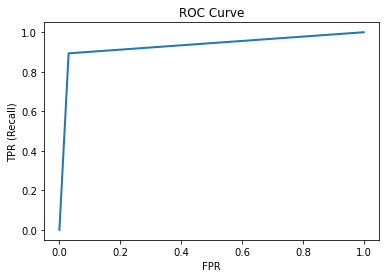

In [355]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(train_generator.labels, train_pred2lab)

sns.lineplot(x=fpr, y=tpr, linewidth=2)
plt.title('ROC Curve')
plt.xlabel('FPR'),
plt.ylabel('TPR (Recall)');

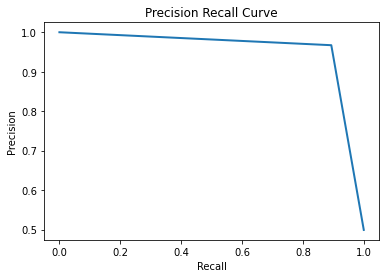

In [356]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(train_generator.labels, train_pred2lab)

sns.lineplot(x=recalls, y=precisions, linewidth=2)
plt.title('Precision Recall Curve')
plt.xlabel('Recall'),
plt.ylabel('Precision');

Text(0.5, 1.0, 'Looks like a cat with probability 0.9925180277787149')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9622808881103992')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9987327456474304')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9999833106994629')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9576803222298622')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9945135456509888')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9999576807022095')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9761329311877489')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9936664975248277')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9954671007581055')

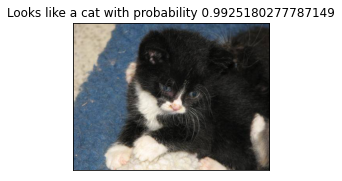

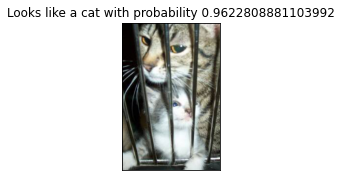

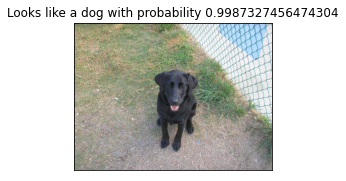

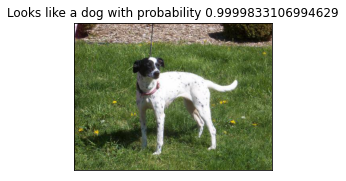

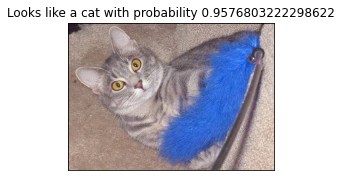

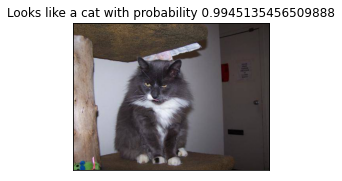

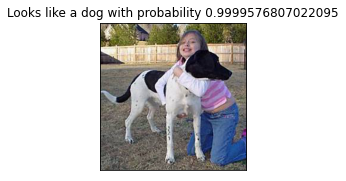

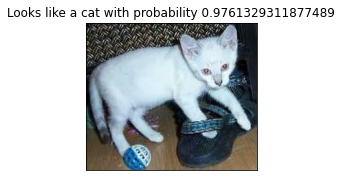

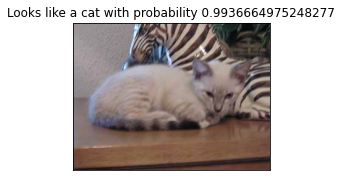

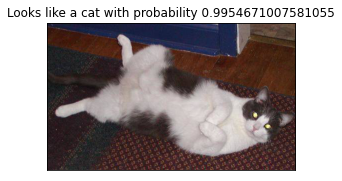

In [320]:
# sample of predictions on test set
n = 10
for i, (index, row) in enumerate(testdf.iterrows()):
    if i >= n:
        break
    fig = plt.figure(figsize=(8, 32))
    img = load_img(row['id'])
    subfig = fig.add_subplot(n, 1, i + 1)
    pred = test_pred2[i][0]
    pred_label = 'dog' if pred > 0.5 else 'cat'
    pred = pred if pred > 0.5 else 1-pred
    plt.title('Looks like a {0} with probability {1}'.format(pred_label, pred))
    f = plt.imshow(img)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

In [328]:
results = pd.DataFrame({'id': pd.Series(testdf.id.values),
                        'label': pd.Series(test_pred2.T[0])})
results.to_csv('results_vgg16.csv', index=False)
results.head(5)

,id,label
0,/Users/alisonau/tensorflow-test/test/9733.jpg,0.01
1,/Users/alisonau/tensorflow-test/test/63.jpg,0.04
2,/Users/alisonau/tensorflow-test/test/6400.jpg,1.00
3,/Users/alisonau/tensorflow-test/test/823.jpg,1.00
4,/Users/alisonau/tensorflow-test/test/4217.jpg,0.04


### VGG16 Model v2

In [358]:
# Build model
cnn3 = VGG16(weights='imagenet', include_top=False, input_shape = (mysize, mysize, 3))

# Build the rest of the model
x = cnn3.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
predictions = keras.layers.Dense(1, activation="sigmoid", name='classifier')(x)
model3=keras.Model(inputs = cnn3.input, outputs = predictions)
model3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 130, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 130, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 130, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 65, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 65, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 65, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [433]:
# set shuffle back to True
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=True,
                                                    batch_size=mybatch,
                                                    seed=42)

Found 20019 validated image filenames belonging to 2 classes.


In [359]:
# fit model v3
# add step size, monitor and stop based on val loss, add more epochs (30 vs. 20)
reset_keras()

checkpoint = keras.callbacks.ModelCheckpoint("modelvgg16v2.h5",
                                             monitor='val_loss',
                                             save_best_only=True)
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=5,
                                      restore_best_weights=True)

SGD = tf.keras.optimizers.SGD(learning_rate = 0.0001, nesterov=True)
model3.compile(optimizer=SGD,
              loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

start = datetime.now()

history3 = model3.fit(train_generator, 
                    steps_per_epoch=step_size, 
                    epochs=30, 
                    callbacks=[checkpoint, early],
                    validation_data=val_generator)  

end = datetime.now()
print('Time to fit:', end-start)


Epoch 1/30


2022-02-26 16:13:27.959980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.7027 - binary_accuracy: 0.5273

2022-02-26 16:16:59.194990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 225s 359ms/step - loss: 0.7027 - binary_accuracy: 0.5273 - val_loss: 0.6511 - val_binary_accuracy: 0.6635
Epoch 2/30
625/625 [==============================] - 224s 359ms/step - loss: 0.6240 - binary_accuracy: 0.6672 - val_loss: 0.5490 - val_binary_accuracy: 0.7691
Epoch 3/30
625/625 [==============================] - 224s 358ms/step - loss: 0.5207 - binary_accuracy: 0.7592 - val_loss: 0.4273 - val_binary_accuracy: 0.8151
Epoch 4/30
625/625 [==============================] - 224s 358ms/step - loss: 0.4221 - binary_accuracy: 0.8109 - val_loss: 0.3287 - val_binary_accuracy: 0.8653
Epoch 5/30
625/625 [==============================] - 226s 361ms/step - loss: 0.3451 - binary_accuracy: 0.8519 - val_loss: 0.2645 - val_binary_accuracy: 0.8908
Epoch 6/30
625/625 [==============================] - 224s 359ms/step - loss: 0.2974 - binary_accuracy: 0.8727 - val_loss: 0.2321 - val_binary_accuracy: 0.9095
Epoch 7/30
625/625 [==============================]

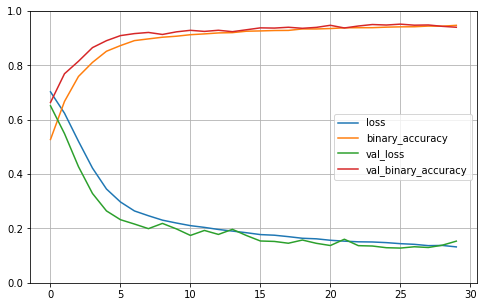

In [360]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [361]:
# set shuffle to False for accuracy metrics
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=None,
                                                    x_col='id',
                                                    y_col='label',
                                                    class_mode='binary',
                                                    target_size=(mysize, mysize),
                                                    shuffle=False,
                                                    batch_size=mybatch,
                                                    seed=42)

Found 20019 validated image filenames belonging to 2 classes.


In [362]:
# predict on train and test
train_generator.reset()
test_generator.reset()

train_pred3 = model3.predict(train_generator, verbose=1)
test_pred3 = model3.predict(test_generator, verbose=1)

2022-02-26 19:31:52.233480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


    7/12500 [..............................] - ETA: 2:04 

2022-02-26 19:34:22.716782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12500/12500 [==============================] - 130s 10ms/step


In [363]:
# create labels based on output which are probabilities
train_pred3lab = train_pred3.copy()

train_pred3lab[train_pred3lab > 0.5] = 1
train_pred3lab[train_pred3lab <= 0.5] = 0

In [364]:
print(classification_report(train_generator.labels, train_pred3lab))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10030
           1       0.92      0.97      0.94      9989

    accuracy                           0.94     20019
   macro avg       0.94      0.94      0.94     20019
weighted avg       0.94      0.94      0.94     20019



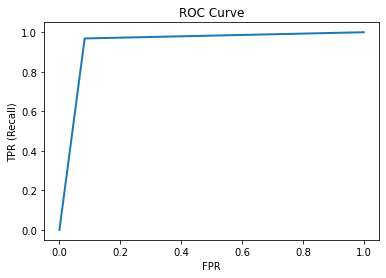

In [365]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(train_generator.labels, train_pred3lab)

sns.lineplot(x=fpr, y=tpr, linewidth=2)
plt.title('ROC Curve')
plt.xlabel('FPR'),
plt.ylabel('TPR (Recall)');

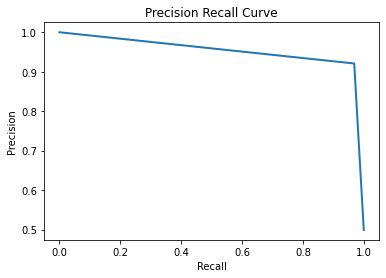

In [366]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(train_generator.labels, train_pred3lab)

sns.lineplot(x=recalls, y=precisions, linewidth=2)
plt.title('Precision Recall Curve')
plt.xlabel('Recall'),
plt.ylabel('Precision');

Text(0.5, 1.0, 'Looks like a cat with probability 0.9909646008163691')

Text(0.5, 1.0, 'Looks like a cat with probability 0.8716691583395004')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9998076558113098')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9999985694885254')

Text(0.5, 1.0, 'Looks like a cat with probability 0.918688215315342')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9955062377266586')

Text(0.5, 1.0, 'Looks like a dog with probability 0.9999953508377075')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9557884335517883')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9916041661053896')

Text(0.5, 1.0, 'Looks like a cat with probability 0.9922623592428863')

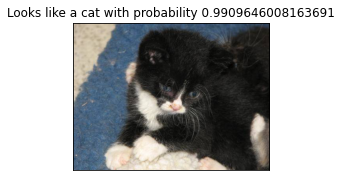

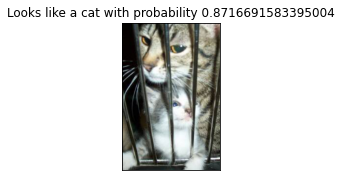

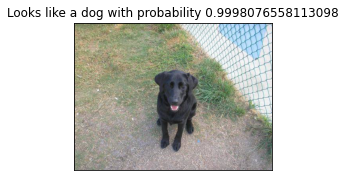

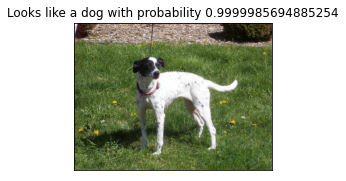

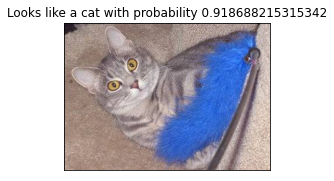

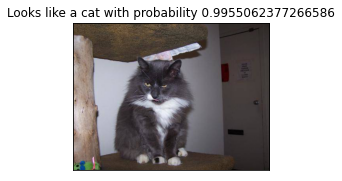

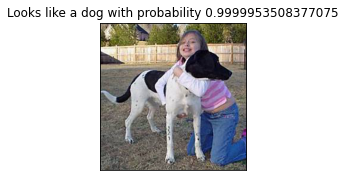

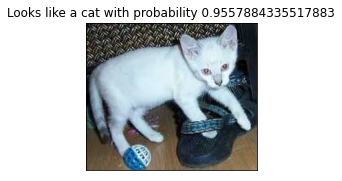

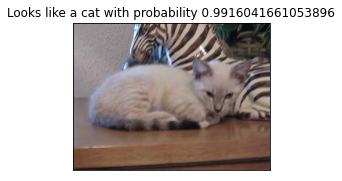

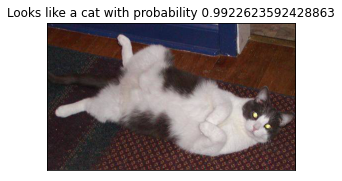

In [367]:
# sample of predictions on test set
n = 10
for i, (index, row) in enumerate(testdf.iterrows()):
    if i >= n:
        break
    fig = plt.figure(figsize=(8, 32))
    img = load_img(row['id'])
    subfig = fig.add_subplot(n, 1, i + 1)
    pred = test_pred3[i][0]
    pred_label = 'dog' if pred > 0.5 else 'cat'
    pred = pred if pred > 0.5 else 1-pred
    plt.title('Looks like a {0} with probability {1}'.format(pred_label, pred))
    f = plt.imshow(img)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

In [368]:
results = pd.DataFrame({'id': pd.Series(testdf.id.values),
                        'label': pd.Series(test_pred3.T[0])})
results.to_csv('results_vgg16v2.csv', index=False)
results.head(5)

,id,label
0,/Users/alisonau/tensorflow-test/test/9733.jpg,0.01
1,/Users/alisonau/tensorflow-test/test/63.jpg,0.13
2,/Users/alisonau/tensorflow-test/test/6400.jpg,1.00
3,/Users/alisonau/tensorflow-test/test/823.jpg,1.00
4,/Users/alisonau/tensorflow-test/test/4217.jpg,0.08
